In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import collections

In [57]:
class GridWorld:
    
    """Gridworld as MDP"""
    def __init__(self, m, n):
        """ initializes the gridworld
        """
        self.m = m
        self.n = n
        self.grid = np.zeros(shape = (m,n))
        self.end = False
        self.goal_tile = 60
        self.wall_tile = 100
        self.ice_tile = 30
        self.figure = 0
        self.free_tile = 230

        # fill the grid with free tiles
        for i in range(self.m):
            for j in range(self.n):
                self.grid[i,j] = self.free_tile
        # possible actions
        self.actions = ["up", "down", "right", "left"]

        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
    
        self.grid[1][1] = self.ice_tile
        self.grid[1][4]= self.ice_tile
        self.grid[1][3] = self.wall_tile
        
    def reset(self):
        """ resets the gridworld
        """
        self.end = False
        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
        
        self.grid[1][1] = self.ice_tile
        self.grid[1][4] = self.ice_tile

    def __getitem__(self, grid):
        """ returns the grid

        Args:
            grid (np_array): gridworld
        """
        print(self.grid)
        return self.grid

        
    def visualize_grid(self):
        """ visualizes the gridworld
        """
        fig, ax = plt.subplots()
        ax.matshow(self.grid, cmap = 'Pastel1')
        for i in range(self.grid.shape[1]):
            for j in range(self.grid.shape[0]):
                # create a string for the label of each tile in the right format
                if str(self.grid[j,i]) == str(float(self.free_tile)):
                    label = " "
                elif str(self.grid[j,i]) == str(float(self.wall_tile)):
                    label = "wall"
                elif str(self.grid[j,i]) == str(float(self.ice_tile)):
                    label = "ice"
                elif str(self.grid[j,i]) == str(float(self.goal_tile)):
                    label = "goal"
                elif str(self.grid[j,i]) == str(float(self.figure)):
                    label = "agent"
                else:
                    label = str(self.grid[j,i])
                ax.text(i, j, label, va = 'center', ha = 'center')
        plt.show()

    def current_pos(self):
        """ returns the current position of the agent
        """
        found = False
        for x in range(self.m):
            for y in range(self.n):
                if self.grid[x,y] == self.figure:
                    found = True
                    break
            if found == True:
                break
        return x,y
    
    def action_parameter(self, action):
        """ returns the next tile and the tile after the next tile and if the next tile is in the grid

        Args:
            action (str): action that the agent should take
        """
        x, y = self.current_pos()
        con = False
        con2 = False
        if action == "up":
            next = x-1,y
            next_two = x-2,y
            if x-1 >= 0:
                con = True
            if x-2 >= 0:
                con2 = True

        elif action == "down":
            next = x+1,y
            next_two = x+2,y
            if x+1 <= self.m-1:
                con = True
            if x+2 <= self.m-1:
                con2 = True

        elif action == "right":
            next = x,y+1
            next_two = x,y+2
            if y+1 <= self.n-1:
                con = True
            if y+2 <= self.n-1:
                con2 = True
        elif action == "left":
            next = x,y-1
            next_two = x,y-2
            if y-1 >= 0:
                con = True
            if y-2 >= 0:
                con2 = True
        return next, next_two, con, con2
            
    def move(self, action):
        """ move the agent according to the action

        Args:
            action (str):  action that the agent should take
        """
        if action != None:
            next, next_two, con, con2 = self.action_parameter(action)
            x, y = self.current_pos()
            if con == True:
                self.grid[x,y] = self.free_tile
                # if the agent reaches the goal, the game ends
                if self.grid[next] == self.goal_tile:
                    # self.grid[next] = self.figure
                    self.end = True
                # if the agent reaches an icy tile, it moves two steps left
                elif self.grid[next] == self.ice_tile and con2 == True:
                    if self.grid[next_two] == self.goal_tile:
                        # self.grid[next_two] == self.figure
                        self.end = True
                    elif self.grid[next_two] == self.wall_tile:
                        self.grid[next] = self.figure
                    else:
                        self.grid[next_two] = self.figure          
                # if the agent reaches a wall, it cannot move
                elif self.grid[next] == self.wall_tile:
                    self.grid[x,y] = self.figure
                elif self.grid[next] == self.free_tile:
                    self.grid[next] = self.figure

    def get_reward(self, next):
        """ Returns the reward of the agent

        Args:
            next (tuple): next position of the agent
        """
        if next == self.goal_tile:
            return 100
        else:
            return -1

    def initialize_policy(self):
        """ Initializes the policy of the agent
        """
        policy = np.zeros(shape = (self.m, self.n, len(self.actions)))
        for i in range(self.m):
            for j in range(self.n):
                for k in range(len(self.actions)):
                    policy[i,j,k] = 1/len(self.actions)
        return policy


    def mc_estimation(self, num_episodes, discount_factor, alpha, epsilon, anneal_epsilon=False):
        """Monte Carlo estimation

        Args:
            num_episodes (int): number of episodes
            gamma (int): discount factor
            epsilon (int): epsilon
        """
        # The final action-value function.
        # A nested dictionary that maps state -> (action -> action-value).
        Q = np.zeros(shape = (self.m, self.n, len(self.actions)))
        gamma = discount_factor

        # create the statistics for the episode
        return_per_episode = []
        average_return_per_episode = []
        

        # The policy we're following
        # policy = self._construct_epsilon_greedy_policy(Q, epsilon, len(self.actions))
        policy = self.greedy_policy(Q, epsilon, len(self.actions))
        # time
        time_per_episode = []
        # track a specific q value
        q_value = []
        counts = []

        # For every episode
        for i_episode in range(num_episodes):
            # Reset the environment and pick the first action
            self.reset()
            state = self.current_pos()
            action = np.random.choice(self.actions, p=policy(state))
    
            # One step in the environment
            t = 0

            # wallclock time
            start_time = time.time()
            temp = []
            episode = []     
            count = 0

            while self.end == False:
                # Take a step
                reward = self.get_reward(self.current_pos())
                count+=1
                next_state = self.current_pos()
                next_action = np.random.choice(self.actions, p=policy(next_state))
                self.move(next_action)
                
                # Update statistics
                temp.append(reward)
                episode.append((state, action, reward))

                if self.end:
                    break

                state = next_state
                action = next_action

            # end wallclock time
            end_time = time.time()
            time_per_episode.append(end_time-start_time)

            G = 0
            list = []
            for index, (state, action, reward) in enumerate(episode):    
                G += reward * gamma**index
                list.append(G)       
                # convert the action to aan integer if it is a string
                if isinstance(action, str):
                    action = self.actions.index(action)         

                # Update Q
                Q[state][action] +=  alpha*(reward + gamma*(G - Q[state][action]))

                # # q value is the starting state down action
                if Q[state][action] == Q[0][0][1]:
                        q_value.append(Q[state][action])

                # Update policy with the new Q
                policy = self.greedy_policy(Q, epsilon, len(self.actions))

            average_return_per_episode.append(np.mean(list))

            if anneal_epsilon:
                epsilon = epsilon * 0.99

            list.clear()
            temp.clear()   
            episode.clear()
            self.reset()
            
        return Q, policy, time_per_episode, average_return_per_episode, counts, q_value

    def sarsa(self, num_episodes, discount_factor, alpha, epsilon, anneal_epsilon=False):
        """
        SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
        
        Args:
            num_episodes: Number of episodes to run for.
            discount_factor: Gamma discount factor.
            alpha: TD learning rate.
            epsilon: Chance the sample a random action. Float betwen 0 and 1.
            anneal_epsilon: If true, epsilon will be annealed to zero over time.
        """
        # The final action-value function.
        # A nested dictionary that maps state -> (action -> action-value).
        Q = np.zeros(shape = (self.m, self.n, len(self.actions)))

        # create the statistics for the episode
        return_per_episode = []
        average_return_per_episode = []

        # The policy we're following
        policy = self.greedy_policy(Q, epsilon, len(self.actions))

        # time
        time_per_episode = []

        # track a specific q value
        q_value = []


        # For every episode
        for i_episode in range(num_episodes):
            # Reset the environment and pick the first action
            #state = self.agent_pos
            state = self.current_pos()
            #action_probs = policy(state)
            #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action = "right"
            self.move(action)

            # One step in the environment
            #for t in itertools.count():
            t = 0
            # wallclock time
            start_time = time.time()
            temp = []

            while self.end == False:
                # Take a step
                reward = self.get_reward(self.current_pos())
                next_state = self.current_pos()
                next_action = np.random.choice(self.actions, p=policy(next_state))
                self.move(next_action)
                
                # Update statis for the return
                temp.append(reward)
                
                # convert the action to aan integer if it is a string
                if isinstance(action, str):
                    action = self.actions.index(action)
                if isinstance(next_action, str):
                    next_action = self.actions.index(next_action)
                
                # convert the action to an integer
                Q[state][action] += alpha * (reward + discount_factor * Q[next_state][next_action] - Q[state][action])
                
                # q value is the starting state down action
                if Q[state][action] == Q[0][0][1]:
                    q_value.append(Q[state][action])

                if self.end:
                    break

                state = next_state
                action = next_action
      
            self.reset()
            # end wallclock time
            end_time = time.time()
            time_per_episode.append(end_time-start_time)

            # we need to calculate the return for the episode
            G = 0
            for index, reward in enumerate(temp):
                G += reward * discount_factor**index
            return_per_episode.append(G)
            average_return_per_episode.append(sum(return_per_episode) / len(return_per_episode))

            # Once the episode is done, we need to anneal epsilon if necessary
            if anneal_epsilon:
                epsilon = epsilon * 0.99

        return Q, policy, time_per_episode, return_per_episode, average_return_per_episode, q_value
        
    def greedy_policy(self, Q, epsilon, nA):
        """
        Creates an epsilon-greedy policy based on a given Q-function and epsilon.
        
        Args:
            Q: A dictionary that maps from state -> action-values.
                Each value is a numpy array of length nA (see below)
            epsilon: The probability to select a random action . float between 0 and 1.
            nA: Number of actions in the environment.
        
        Returns:
            A function that takes the observation as an argument and returns
            an action according to the probabilities.
        """
        def policy_fn(state):
            A = np.ones(nA, dtype=float) * epsilon / nA
            best_action = np.argmax(Q[state])
            A[best_action] += (1.0 - epsilon)
            return A
        return policy_fn


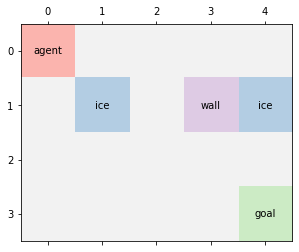

In [58]:
env = GridWorld(4,5)
env.visualize_grid()

# SARSA

In [59]:
# calculate sarsa
q_values_sarsa = []
for i in tqdm(range(100)):
    Q_sarsa, policy_sarsa, time_per_episode_sarsa, return_per_episode_sarsa, average_return_per_episode_sarsa, q_value_sarsa = env.sarsa(1000, 0.95, 0.1, 0.1, True)
    q_values_sarsa.append(q_value_sarsa)

  0%|          | 0/100 [00:00<?, ?it/s]

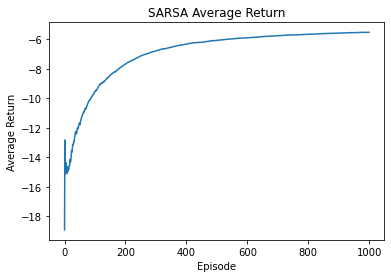

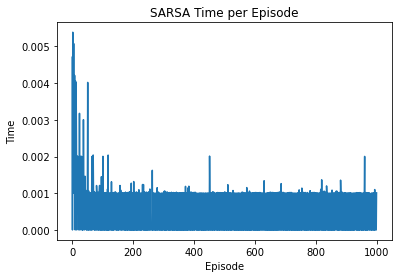

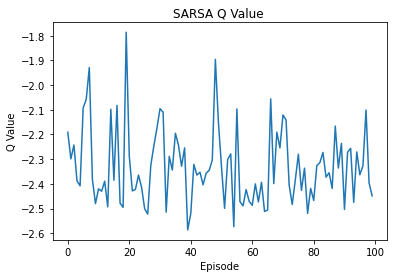

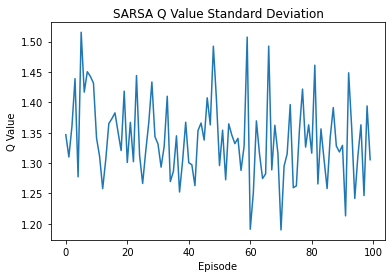

In [60]:
# visualize sarsa average return
plt.plot(average_return_per_episode_sarsa)
plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.title("SARSA Average Return")
plt.show()

# visualize sarsa time per episode
plt.plot(time_per_episode_sarsa)
plt.xlabel("Episode")
plt.ylabel("Time")
plt.title("SARSA Time per Episode")
plt.show()

# create a lineplot including mean and standard deviation vs episode of the q values
# calculate the mean and standard deviation of the q values
mean_q_values_sarsa = []
std_q_values_sarsa = []

# use q_value_sarsa
for i in q_values_sarsa:
    mean_q_values_sarsa.append(np.mean(i))
    std_q_values_sarsa.append(np.std(i))

# create the lineplot
plt.plot(mean_q_values_sarsa)
plt.xlabel("Episode")
plt.ylabel("Q Value")
plt.title("SARSA Q Value ")
plt.show()

# create the lineplot
plt.plot(std_q_values_sarsa)
plt.xlabel("Episode")
plt.ylabel("Q Value")
plt.title("SARSA Q Value Standard Deviation")
plt.show()


In [64]:
print(len(q_values_sarsa))

100


# MC-Control

In [61]:
q_values = []
for i in tqdm(range(100)):
    Q, policy, time_per_episode, average_return_per_episode, counts, q_value = env.mc_estimation(1000, 0.95, 0.1, 0.1, True)
    q_values.append(q_value)

  0%|          | 0/100 [00:00<?, ?it/s]

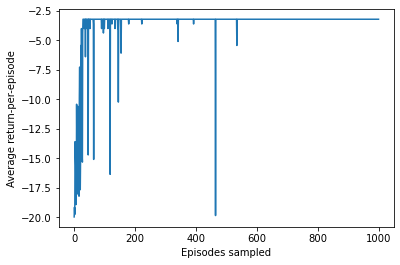

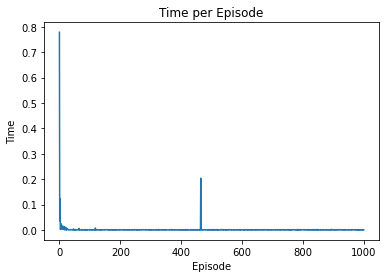

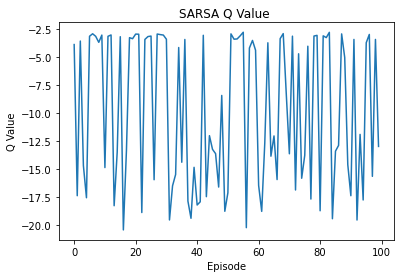

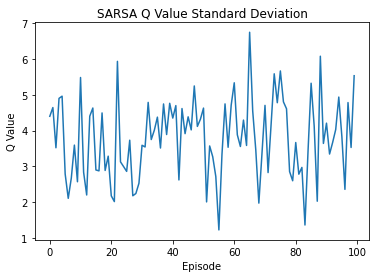

In [62]:
#visualize average return-per-episode in episodes-sampled
x = list(range(1000))

# print(average_returns)
y = average_return_per_episode

# print(average_returns)
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Average return-per-episode')
plt.show()

# visualize time per episode
plt.plot(time_per_episode)
plt.xlabel("Episode")
plt.ylabel("Time")
plt.title("Time per Episode")
plt.show()

# create a lineplot including mean and standard deviation vs episode of the q values
# calculate the mean and standard deviation of the q values
mean_q_values = []
std_q_values = []

# use q_value_sarsa
for i in q_values:
    mean_q_values.append(np.mean(i))
    std_q_values.append(np.std(i))

# create the lineplot
plt.plot(mean_q_values)
plt.xlabel("Episode")
plt.ylabel("Q Value")
plt.title(" Q Value ")
plt.show()

# create the lineplot
plt.plot(std_q_values)
plt.xlabel("Episode")
plt.ylabel("Q Value")
plt.title("Q Value Standard Deviation")
plt.show()


# Interpretation of the results

